# Import libraries

In [1]:
import pandas as pd
import time
import sys
import numpy as np

import seaborn as sns
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})
import matplotlib.pyplot as plt

# Define parameters

In [2]:
# Main path
root_path = r"C:\Users\Sonita\Documents\KU_Leuven\Subjects\2022-1\Modern Data Analytics\5. New_Project\github"

# Path for data
data_path = root_path + r"\data"

# Path for codes
code_path = root_path + r"\code"

# Path for outputs
output_path = root_path + r"\output"

# Define colors to use in plots
colors = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da","darkblue"]

# Import my functions module

In [3]:
sys.path.append(code_path)

from my_functions import read_gbd, full_describe, treatoutliers

# Read data

In [4]:
start_time = time.time()

# Read country codes
country_codes = pd.read_csv("https://raw.githubusercontent.com/soniasocadagui/mdaheatwaves/main/data/country%20codes/country_codes.csv", sep=";", encoding="latin1")

# Read data associated to temperature
temper_data = pd.read_csv(data_path + "\\" + r"Temperature data\weather_data.csv", parse_dates=['utc_timestamp'])

# Read data associated to Suicide rate estimates
suicide_data = pd.read_csv("https://raw.githubusercontent.com/soniasocadagui/mdaheatwaves/main/data/Suicide%20rate%20estimates%2C%20crude/suicide.csv")

# Read data associated to population
popul_data = pd.read_csv("https://raw.githubusercontent.com/soniasocadagui/mdaheatwaves/main/data/population/population.csv", sep=";", skiprows=4)

# Read data associated to Global Burden of Disease study (GBD)
GBD_data = read_gbd(data_path,"Global Burden of Disease study")

print("Execution time:", time.time() - start_time, " seconds")

Execution time: 14.572167158126831  seconds


# Data wrangling

### - Temperature data processing

In [5]:
# Determine columns that contain temperature
temper_cols = [col for col in temper_data.columns if 'temperature' in col]

# Filter out columns not containing temperature
temper_data_filt = temper_data[temper_cols + ['utc_timestamp']].copy()

# Get year
temper_data_filt['Year'] = temper_data_filt.utc_timestamp.dt.year

# Delete unnecesary columns
del temper_data_filt['utc_timestamp']

# Get mean temperature
temper_mean = temper_data_filt.groupby('Year').mean().reset_index()

# Reshape to get long data format
temper_mean = pd.melt(temper_mean, id_vars='Year', value_vars=temper_cols, value_name='Mean_temperature',
                      ignore_index=False)

# Get minimum temperature
temper_min = temper_data_filt.groupby('Year').min().reset_index()

# Reshape to get long data format
temper_min = pd.melt(temper_min, id_vars='Year', value_vars=temper_cols, value_name='Min_temperature',
                     ignore_index=False)

# Get maximum temperature
temper_max = temper_data_filt.groupby('Year').max().reset_index()

# Reshape to get long data format
temper_max = pd.melt(temper_max, id_vars='Year', value_vars=temper_cols, value_name='Max_temperature',
                     ignore_index=False)

# Put results together
temper = pd.merge(temper_mean, temper_min, on=['Year', 'variable'], how='inner')
temper = pd.merge(temper, temper_max, on=['Year', 'variable'], how='inner')

# Remove "_temperature" from country code
temper['variable'] = temper['variable'].str.replace('_temperature', '')

### - Suicide data processing

In [6]:
# Filter sex (selecting both)
suicide_df = suicide_data[suicide_data['SEX (CODE)'] == "BTSX"]

# Keep useful columns
suicide_df = suicide_df[['YEAR (DISPLAY)', 'COUNTRY (CODE)', 'Numeric', 'Low', 'High']]

# Rename columns
suicide_df.columns = ['Year', 'Country_code3', 'suicide_rate_est', 'suicide_rate_low', 'suicide_rate_high']

In [7]:
# Filter sex (selecting men)
suicide_df_MEN = suicide_data[suicide_data['SEX (CODE)'] == "MLE"]

# Keep useful columns
suicide_df_MEN = suicide_df_MEN[['YEAR (DISPLAY)', 'COUNTRY (CODE)', 'Numeric', 'Low', 'High']]

# Rename columns
suicide_df_MEN.columns = ['Year', 'Country_code3', 'suicide_rate_est_MEN', 'suicide_rate_low_MEN',
                          'suicide_rate_high_MEN']

In [8]:
# Filter sex (selecting women)
suicide_df_WMEN = suicide_data[suicide_data['SEX (CODE)'] == "FMLE"]

# Keep useful columns
suicide_df_WMEN = suicide_df_WMEN[['YEAR (DISPLAY)', 'COUNTRY (CODE)', 'Numeric', 'Low', 'High']]

# Rename columns
suicide_df_WMEN.columns = ['Year', 'Country_code3', 'suicide_rate_est_WMEN', 'suicide_rate_low_WMEN',
                           'suicide_rate_high_WMEN']

### - Population data processing

In [9]:
# Get years (from columns names)
years_str = [x for x in popul_data.columns if
             x not in ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']]

# Reshape to get long data format
popul_df = pd.melt(popul_data, id_vars='Country Code', value_vars=years_str, value_name='Population',
                   ignore_index=False)

# Rename columns
popul_df.columns = ['Country_code3', 'Year', 'Population']

# Convert column
popul_df['Year'] = popul_df['Year'].astype(int)

### - Global Burden of Disease study (GBD) data processing

In [10]:
# Get lowercase country name to join later
GBD_data['Country_cross'] = GBD_data['location_name'].str.lower()

# Keep thre first letters of metric name
GBD_data['metric_name'] = GBD_data['metric_name'].astype(str).str[0:3]

# Keep thre first letters of metric name
GBD_data['measure_name'] = GBD_data.measure_name.str.split().str.get(0)

In [11]:
# Select filters desired
filter_measure_name = ["Prevalence", "Deaths", "YLDs"]
filter_sex_name = ["Both"]

# filter_metric_name = ""
filter_cause_name = ["Mental disorders",
                     "Respiratory infections and tuberculosis",
                     "Neoplasms",
                     "Cardiovascular diseases",
                     "Chronic respiratory diseases",
                     "Neurological disorders",
                     "Substance use disorders",
                     "Diabetes and kidney diseases",
                     "Skin and subcutaneous diseases",
                     "Musculoskeletal disorders",
                     "Nutritional deficiencies",
                     "Digestive diseases",
                     "Malignant skin melanoma",
                     "Lip and oral cavity cancer",
                     "Tracheal, bronchus, and lung cancer",
                     "Non-melanoma skin cancer",
                     "Total cancers"]

In [12]:
# List of final filters
total_filters = [[a, b, c] for a in filter_measure_name
                           for b in filter_sex_name
                           for c in filter_cause_name]

In [13]:
# Get three first particles of words to generate names
part_measure_name = ['_'.join([x[0:3] for x in s.split()]) for s in filter_measure_name]
part_sex_name = ['_'.join([x[0:3] for x in s.split()]) for s in filter_sex_name]
part_cause_name = ['_'.join([x[0:3] for x in s.split()]) for s in filter_cause_name]

In [14]:
# New names of the processed variables
names_newcols = ['-'.join([a, b, c]) for a in part_measure_name
                                     for b in part_sex_name
                                     for c in part_cause_name]

In [15]:
# Apply filters to create final gbd dataframe
vars_GBD_df =[]
count = -1

for i in total_filters:

    count += 1

    # Filter data with parameters specified
    filter_GBD_data = GBD_data[(GBD_data.measure_name == i[0]) &
                               (GBD_data.sex_name == i[1]) &
                               (GBD_data.cause_name == i[2])]

    # Reshape to get wide format
    vars_GBD_temp = pd.pivot(filter_GBD_data,
                             index=['year', 'Country_cross'],
                             columns='metric_name',
                             values='val').reset_index()

    # Rename columns
    vars_GBD_temp.columns = ['Year', 'Country_cross']+\
                            ['-'.join([a,names_newcols[count]]) for a in vars_GBD_temp.columns[2:]]
    vars_GBD_temp.set_index(['Year', 'Country_cross'],inplace=True)

    vars_GBD_df.append(vars_GBD_temp)

GBD_df = pd.concat(vars_GBD_df, axis=1, ignore_index=False)
GBD_df.reset_index(drop=False, inplace=True)

# Joining data

In [16]:
# Change name for country code (to join with country code table)
temper_df = temper.copy()
temper_df.rename(columns={'variable': 'Country_code'}, inplace=True)

# Join temperature data with country code
temper_df = pd.merge(temper_df, country_codes[['Country', 'Country_code', 'Country_code3']], on=['Country_code'],
                     how='left')

# Change name of countries to increase crossing rate
temper_df['Country'] = np.where(temper_df['Country'] == 'United Kingdom of Great Britain and Northern Ireland (the)',
                                'United Kingdom',
                                np.where(temper_df['Country'] == 'Netherlands (the)', 'Netherlands',
                                         temper_df['Country']
                                         ))

# Join temperature data with suicide tables
whole_df = pd.merge(temper_df, suicide_df, on=['Year', 'Country_code3'], how='left')  # 560 crossing
whole_df = pd.merge(whole_df, suicide_df_MEN, on=['Year', 'Country_code3'], how='left')  # 560 crossing
whole_df = pd.merge(whole_df, suicide_df_WMEN, on=['Year', 'Country_code3'], how='left')  # 560 crossing

# Join with population table
whole_df = pd.merge(whole_df, popul_df, on=['Year', 'Country_code3'], how='left')  # 1120 crossing

# Join with gbd table
whole_df['Country_cross'] = whole_df['Country'].str.lower()
whole_df = pd.merge(whole_df, GBD_df, on=['Year', 'Country_cross'], how='left')  # 840 crossing

# Feature engineering

In [17]:
# Determine columns that contain temperature
temper_cols = [col for col in temper_data.columns if 'temperature' in col]

# Filter out columns not containing temperature
temper_data_filt = temper_data[temper_cols + ['utc_timestamp']].copy()

# Get year
temper_data_filt['Year'] = temper_data_filt.utc_timestamp.dt.year

# Get month
temper_data_filt['Month'] = temper_data_filt.utc_timestamp.dt.month

# Get day
temper_data_filt['Day'] = temper_data_filt.utc_timestamp.dt.day

# Delete unnecesary columns
del temper_data_filt['utc_timestamp']

# Get maximum temperature per day
temper_max = temper_data_filt.groupby(['Year', 'Month', 'Day']).max().reset_index()

# Reshape to get long data format
temper_max = pd.melt(temper_max, id_vars=['Year', 'Month', 'Day'], value_vars=temper_cols, value_name='Max_temperature',
                     ignore_index=False)

# Remove "_temperature" from country code
temper_max['variable'] = temper_max['variable'].str.replace('_temperature', '')

# Change name for country code
temper_max.rename(columns={'variable': 'Country_code'}, inplace=True)

In [18]:
# Filter in data before year 2000 (base period to constrast temperature)
bef_2000 = temper_max[temper_max['Year'] < 2000]

# Filter in data after year 2000 (included) (period of analysis for clusters)
aft_2000 = temper_max[temper_max['Year'] >= 2000]

# Get percentile 99 by country for the daily-based maximum temperature
perc_99_crtl_period = bef_2000[['Country_code', 'Max_temperature']].groupby('Country_code').quantile(0.99).reset_index()

# Change name for country code
perc_99_crtl_period.rename(columns={'Max_temperature': 'Control_temperature'}, inplace=True)

In [19]:
# Join to compare current daily temperature with control period
heat_high_flags = pd.merge(temper_max, perc_99_crtl_period, on=['Country_code'], how='left')

# Mark high temperature
heat_high_flags['High_temperature'] = np.where(
    heat_high_flags['Max_temperature'] > heat_high_flags['Control_temperature'], 1, 0)

# Sort by country and date
heat_high_flags = heat_high_flags.sort_values(by=['Country_code', 'Year', 'Month', 'Day'])

In [20]:
# Define variable to use in cumulative days
heat_high_flags['Counter'] = np.where(heat_high_flags["High_temperature"] == 1, 1, 0)

# Concatenate country and flag for high temperature
heat_high_flags['aux_concat'] = heat_high_flags['Country_code'] + heat_high_flags["High_temperature"].astype(str)

# Calculate number of consecutive days with high temperature
heat_high_flags['consec_days_extreme_temp'] = heat_high_flags['Counter'].groupby(
    heat_high_flags['aux_concat'].ne(heat_high_flags['aux_concat'].shift()).cumsum()).cumsum()

# Mark heat waves
heat_high_flags['Heat_wave'] = np.where(heat_high_flags['consec_days_extreme_temp'] >= 3, 1, 0)

# Export results
heat_high_flags.to_csv(output_path + "\\" + '1.check_heat_wave_flag.csv', index=False, sep=";")

In [21]:
# Get heat waves and extreme temperatures flag by year and country
heat_wave_extr_temp = heat_high_flags.groupby(['Year', 'Country_code']).max().reset_index()

# Calculate number of days with high temperatures and heat waves
days_heat_wave_extr_temp = heat_high_flags.groupby(['Year', 'Country_code']).sum().reset_index()
days_heat_wave_extr_temp.rename(
    columns={'High_temperature': 'Days_w_High_temperature', 'Heat_wave': 'Days_w_Heat_wave'}, inplace=True)

In [22]:
# Join with whole data
whole_df = pd.merge(whole_df,
                    heat_wave_extr_temp[['Year', 'Country_code', 'High_temperature', 'Heat_wave']],
                    on=['Year', 'Country_code'], how='left')

whole_df = pd.merge(whole_df,
                    days_heat_wave_extr_temp[['Year', 'Country_code', 'Days_w_High_temperature', 'Days_w_Heat_wave']],
                    on=['Year', 'Country_code'], how='left')

# Export results
whole_df.to_csv(output_path + "\\" + '2.total_processed_df.csv', index = False, sep = ";")

# Exploratory data Analysis (EDA)

### - Missing analysis

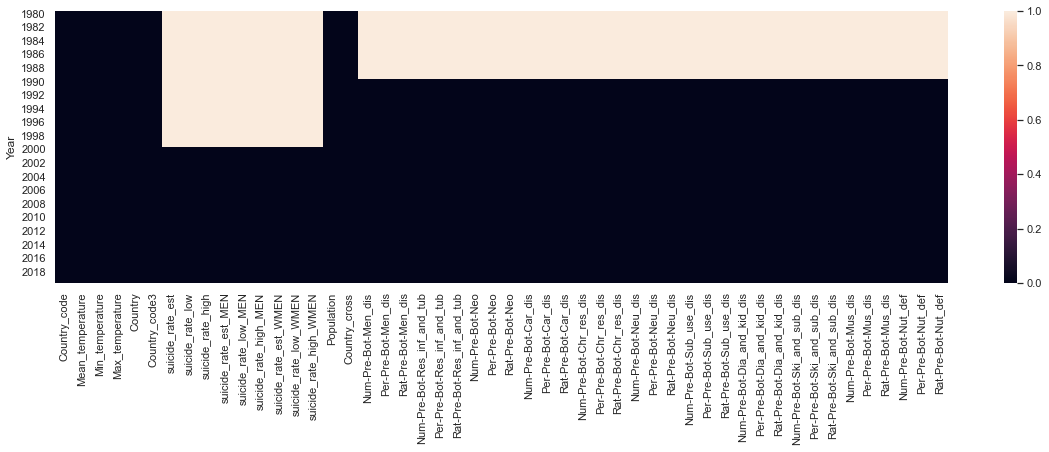

In [23]:
# Calculate missing percentage per year
missing_yearly = 1 - whole_df.groupby('Year').count() / (whole_df.shape[0] / len(np.unique(whole_df.Year)))

# Plot heatmap of missing percentage per year
plt.subplots(figsize=(20, 5))
sns.heatmap(missing_yearly.iloc[:, : 50], annot=False)
plt.show()

In [24]:
# Filter out months without information
filt_year_whole_df = whole_df[whole_df['Year'] >= 2000]

# Applying EDA function to data
summary = full_describe(dataframe=filt_year_whole_df, variability=20, completeness=10)
# summary.to_clipboard(index=True,header=True)

# Export results
summary.to_csv(output_path + "\\" + '3.EDA_filt_year_processed_df.csv', index=True, sep=";")

Describe process started, Time: 19:27:32
Describe process finished. Elapsed Time: 0 segs
Completeness and variability process started, Time: 19:27:32
Completeness and variability process finished. Elapsed time: 0 segs
Complete process finished. Total Elapsed time: 0 segs


In [25]:
# Get variables to be discarded by completeness and variability
vars_remove = summary[
    (summary['completeness_decision'] == 'reject') | (summary['variability_decision'] == 'reject')].index

# Filter out variables rejected
filt_whole_df = filt_year_whole_df.drop(vars_remove, axis=1)

### - Outliers detection and treatment

In [26]:
# Define variables to cap and floor
vars_cap = filt_whole_df.columns
vars_cap = [i for i in vars_cap if i not in ['Year', 'Country_code', 'Mean_temperature', 'Min_temperature'
    , 'Max_temperature', 'Country', 'Country_code3', 'Country_cross'
    , 'High_temperature', 'Heat_wave', 'Days_w_High_temperature', 'Days_w_Heat_wave'
                                             ]]

# Cap and floor variables selected
filt_whole_df = treatoutliers(df=filt_whole_df,
                              columns=vars_cap,
                              method='PCT',
                              treament='cap',
                              pct_min=0.05,
                              pct_max=0.95)

In [27]:
# Export data clusters and models
filt_whole_df.to_csv(output_path + "\\" + '4.filt_year_processed_df.csv', index = False, sep = ";")

### - Univariate analysis

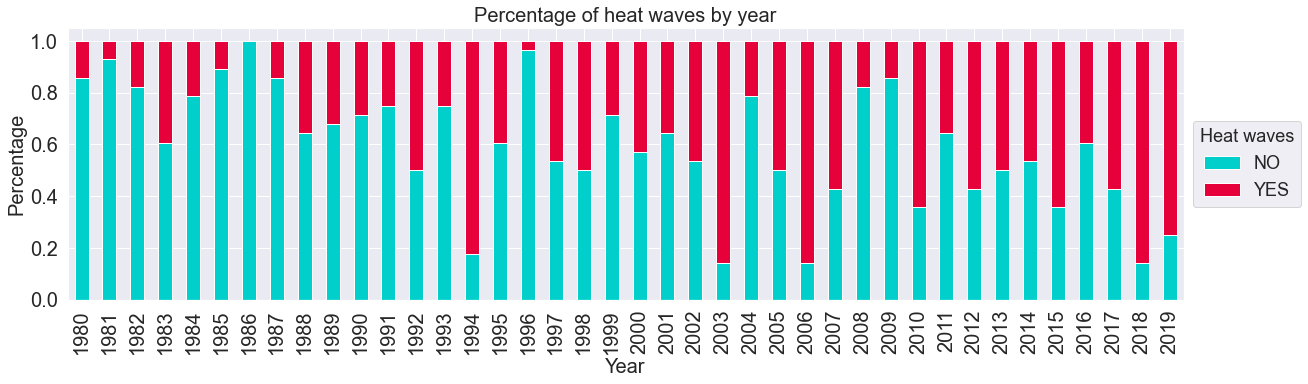

In [29]:
# Get data grouped
cross_table = whole_df.groupby(['Year', 'Heat_wave']).count().reset_index()[['Year', 'Heat_wave', 'Country_code']]

# Reshape to get wide format
cross_table = pd.pivot(cross_table, index=['Year'], columns='Heat_wave').droplevel(0, axis=1).reset_index().fillna(0)
cross_table.columns = ['Year', 'NO', 'YES']

# Calculate percentages
cross_table['NO_pct'] = cross_table['NO'] / (cross_table['NO'] + cross_table['YES'])
cross_table['YES_pct'] = cross_table['YES'] / (cross_table['NO'] + cross_table['YES'])
cross_table = cross_table.drop(['NO', 'YES'], axis=1)

# Plot
fig, axes = plt.subplots(ncols=1, figsize=(20, 5))
cross_table.plot(x='Year', kind='bar', stacked=True, title='Percentage of heat waves by year', ax=axes
                 , color=[colors[0], colors[1]], fontsize=20)

axes.title.set_size(20)
axes.legend(['NO', 'YES'], fontsize=18, loc='center left', bbox_to_anchor=(1.0, 0.5), title="Heat waves",
            title_fontsize=18)
axes.set_xlabel("Year", size=20)
axes.set_ylabel("Percentage", size=20)

# Save plot
plt.savefig(output_path + "\\" + 'plots_kmeans_charact' + "\\" + 'distribution_heatwaves.png')

plt.show()

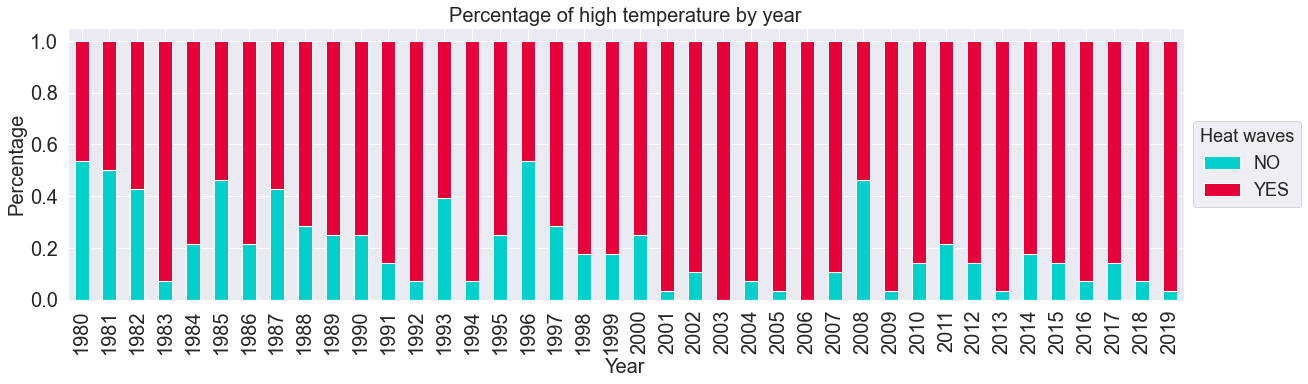

In [30]:
# Get data grouped
cross_table = whole_df.groupby(['Year', 'High_temperature']).count().reset_index()[
                               ['Year', 'High_temperature', 'Country_code']]

# Reshape to get wide format
cross_table = pd.pivot(cross_table,
                       index=['Year'],
                       columns='High_temperature').droplevel(0,axis=1).reset_index().fillna(0)
cross_table.columns = ['Year', 'NO', 'YES']

# Calculate percentages
cross_table['NO_pct'] = cross_table['NO'] / (cross_table['NO'] + cross_table['YES'])
cross_table['YES_pct'] = cross_table['YES'] / (cross_table['NO'] + cross_table['YES'])
cross_table = cross_table.drop(['NO', 'YES'], axis=1)

# Plot
fig, axes = plt.subplots(ncols=1, figsize=(20, 5))
cross_table.plot(x='Year', kind='bar', stacked=True, title='Percentage of high temperature by year', ax=axes
                 , color=[colors[0], colors[1]], fontsize=20)

axes.title.set_size(20)
axes.legend(['NO', 'YES'], fontsize=18, loc='center left', bbox_to_anchor=(1.0, 0.5), title="Heat waves",
            title_fontsize=18)
axes.set_xlabel("Year", size=20)
axes.set_ylabel("Percentage", size=20)

# Save plot
plt.savefig(output_path + "\\" + 'plots_kmeans_charact' + "\\" + 'distribution_high_temperatures.png')

plt.show()

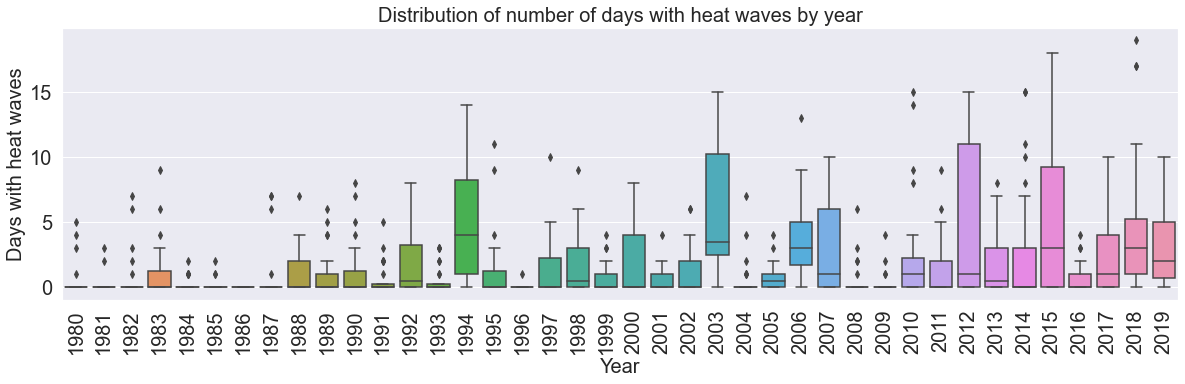

In [31]:
cross_table = whole_df.copy()

plt.subplots(ncols=1, figsize=(20, 5))
b = sns.boxplot(x='Year', y='Days_w_Heat_wave', data=cross_table)
# 'Days_w_High_temperature','Days_w_Heat_wave'
b.axes.set_title("Distribution of number of days with heat waves by year", fontsize=20)
b.set_xlabel("Year", fontsize=20)
b.set_ylabel("Days with heat waves", fontsize=20)
b.tick_params(labelsize=20)
b.tick_params(axis='x', labelrotation=90)
plt.show()

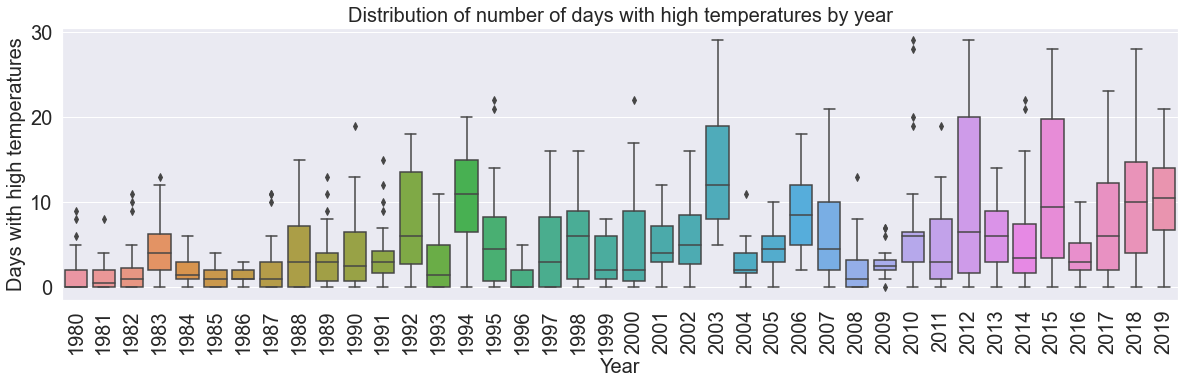

In [32]:
plt.subplots(ncols=1, figsize=(20, 5))
b = sns.boxplot(x='Year', y='Days_w_High_temperature', data=cross_table)

b.axes.set_title("Distribution of number of days with high temperatures by year", fontsize=20)
b.set_xlabel("Year", fontsize=20)
b.set_ylabel("Days with high temperatures", fontsize=20)
b.tick_params(labelsize=20)
b.tick_params(axis='x', labelrotation=90)
plt.show()

In [33]:
# Calculate Pearson correlation
corr = filt_whole_df.corr()

# Export results
corr.to_csv(output_path + "\\" + '5.corr_filt_processed_df.csv', index = True, sep = ";")

In [34]:
# Selected features
list_vars = ['Min_temperature', 'Mean_temperature', 'Max_temperature'
           , 'suicide_rate_est', 'Per-YLD-Bot-Res_inf_and_tub'
           , 'Per-YLD-Bot-Ski_and_sub_dis', 'Per-Dea-Bot-Res_inf_and_tub', 'Per-YLD-Bot-Car_dis'
           , 'Per-Pre-Bot-Sub_use_dis', 'Per-YLD-Bot-Chr_res_dis', 'Per-YLD-Bot-Men_dis'
           , 'Rat-Pre-Bot-Car_dis', 'Rat-Pre-Bot-Dia_and_kid_dis']

corr_filt = corr.filter(items = list_vars, axis=0)
corr_filt = corr_filt[list_vars]

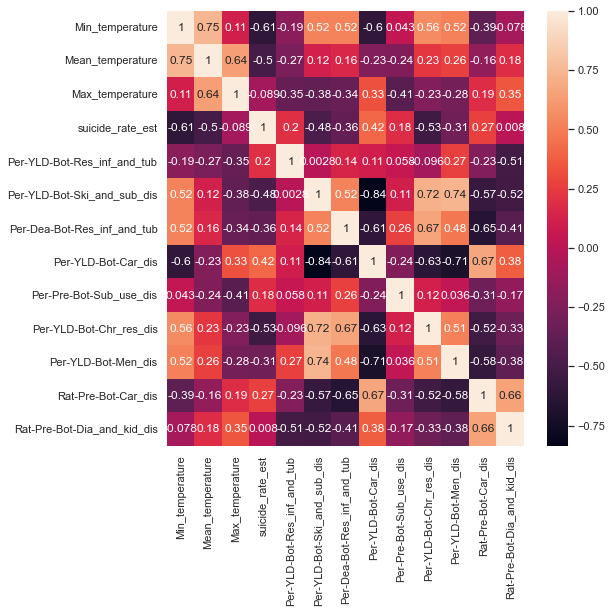

In [36]:
# Plot heatmap of correlations
plt.subplots(figsize=(8, 8))
sns.heatmap(corr_filt, annot=True)

# Save plot
plt.savefig(output_path + "\\" + 'plots_kmeans_charact' + "\\" + 'correlations.png')

plt.show()